In [1]:
# Model Evaluation & Explainability
# Deep dive into model performance and SHAP explanations

# Step 1: Setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

from src.preprocessing import load_data, split_data
from src.modeling import load_model
from src.explainability import ChurnExplainer, generate_explanation_text
from src.config import BEST_MODEL_FILE
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

sns.set_style("whitegrid")
print("✅ Setup complete")


⚠️ LightGBM not available
✅ Setup complete


In [2]:
# Step 2: Load Data and Model
print("="*70)
print("LOADING MODEL AND DATA")
print("="*70)

# Load data
df = load_data()
X_train, X_test, y_train, y_test = split_data(df)

# Load best model
model = load_model(model_path=BEST_MODEL_FILE)
print(f"✅ Loaded production model")

# Get predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)  # Use default threshold for now


LOADING MODEL AND DATA
✅ Loaded data: (200000, 11)
✅ Data split complete:
   Train: (160000, 9)
   Test:  (40000, 9)
   Train churn rate: 43.50%
   Test churn rate:  43.50%
📦 Model loaded: C:\Users\shali\Documents\shalin\google\churn-prediction-system\models\best_model.pkl
✅ Loaded production model



CONFUSION MATRIX ANALYSIS

Confusion Matrix:
                 Predicted
               No    Yes
Actual  No   11,328 11,271
        Yes   1,111 16,290

Breakdown:
True Negatives:  11,328 (Correctly predicted no churn)
False Positives: 11,271 (Predicted churn, but didn't)
False Negatives:  1,111 (Missed churners - COSTLY!)
True Positives:  16,290 (Correctly predicted churn)

Rates:
True Negative Rate:  50.1% (Specificity)
True Positive Rate:  93.6% (Recall/Sensitivity)
False Positive Rate: 49.9%
False Negative Rate: 6.4%


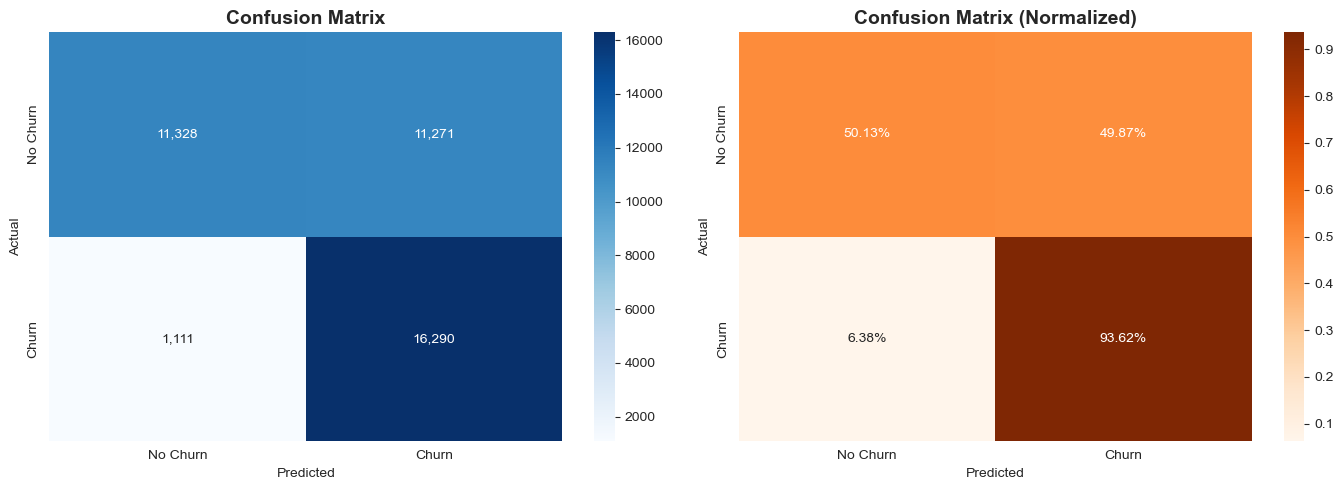

In [3]:
# Step 3: Confusion Matrix Analysis
print("\n" + "="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"               No    Yes")
print(f"Actual  No   {tn:>6,} {fp:>6,}")
print(f"        Yes  {fn:>6,} {tp:>6,}")

print(f"\nBreakdown:")
print(f"True Negatives:  {tn:>6,} (Correctly predicted no churn)")
print(f"False Positives: {fp:>6,} (Predicted churn, but didn't)")
print(f"False Negatives: {fn:>6,} (Missed churners - COSTLY!)")
print(f"True Positives:  {tp:>6,} (Correctly predicted churn)")

# Calculate rates
total_negatives = tn + fp
total_positives = fn + tp

print(f"\nRates:")
print(f"True Negative Rate:  {tn/total_negatives:.1%} (Specificity)")
print(f"True Positive Rate:  {tp/total_positives:.1%} (Recall/Sensitivity)")
print(f"False Positive Rate: {fp/total_negatives:.1%}")
print(f"False Negative Rate: {fn/total_positives:.1%}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


In [4]:
# Step 4: Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

print("\n", classification_report(y_test, y_pred, 
                                   target_names=['No Churn', 'Churn'],
                                   digits=4))



CLASSIFICATION REPORT

               precision    recall  f1-score   support

    No Churn     0.9107    0.5013    0.6466     22599
       Churn     0.5911    0.9362    0.7246     17401

    accuracy                         0.6905     40000
   macro avg     0.7509    0.7187    0.6856     40000
weighted avg     0.7716    0.6905    0.6805     40000




ROC CURVE ANALYSIS
ROC-AUC Score: 0.8369
Optimal threshold (Youden's J): 0.699


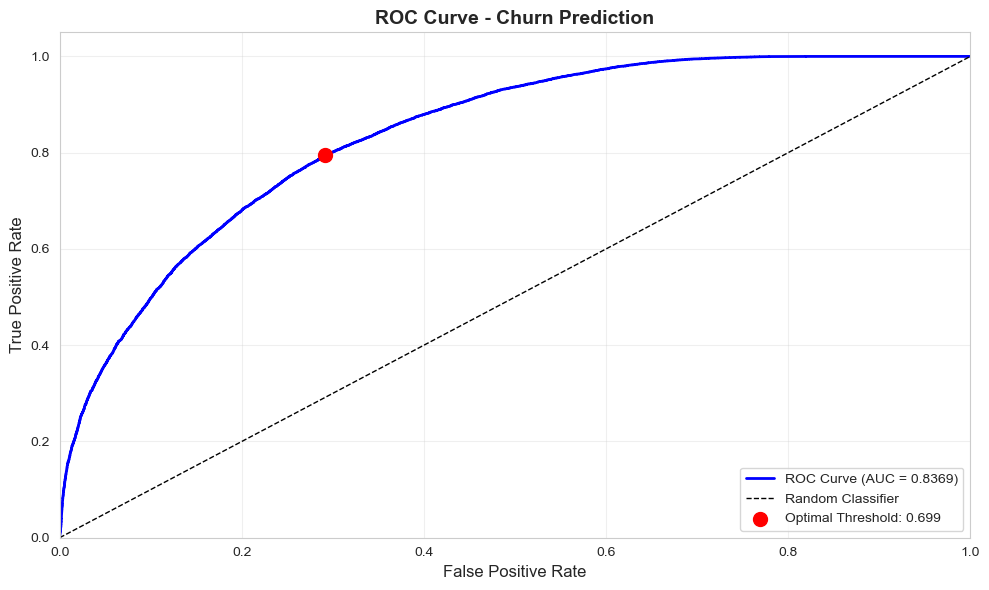

In [5]:
# Step 5: ROC Curve Analysis
print("\n" + "="*70)
print("ROC CURVE ANALYSIS")
print("="*70)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"ROC-AUC Score: {roc_auc:.4f}")

# Find optimal threshold (Youden's index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_roc = thresholds[optimal_idx]
print(f"Optimal threshold (Youden's J): {optimal_threshold_roc:.3f}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], s=100, c='red', 
           label=f'Optimal Threshold: {optimal_threshold_roc:.3f}', zorder=5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Churn Prediction', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



PRECISION-RECALL CURVE
Average Precision Score: 0.7852


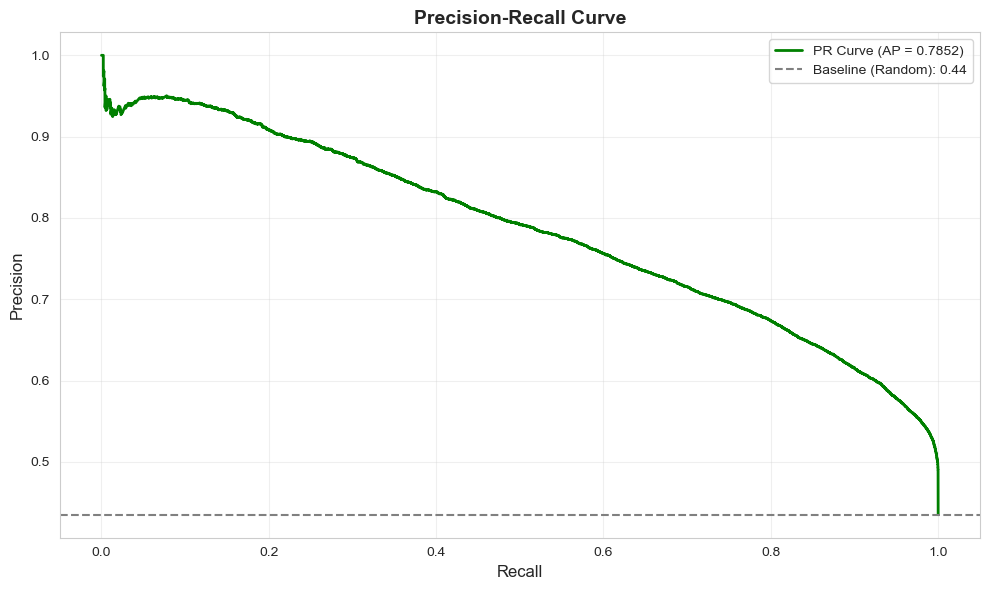

In [6]:
# Step 6: Precision-Recall Curve
print("\n" + "="*70)
print("PRECISION-RECALL CURVE")
print("="*70)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Average Precision Score: {avg_precision:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, color='green', 
        label=f'PR Curve (AP = {avg_precision:.4f})')
plt.axhline(y=y_test.mean(), color='gray', linestyle='--', 
           label=f'Baseline (Random): {y_test.mean():.2f}')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



PREDICTION DISTRIBUTION


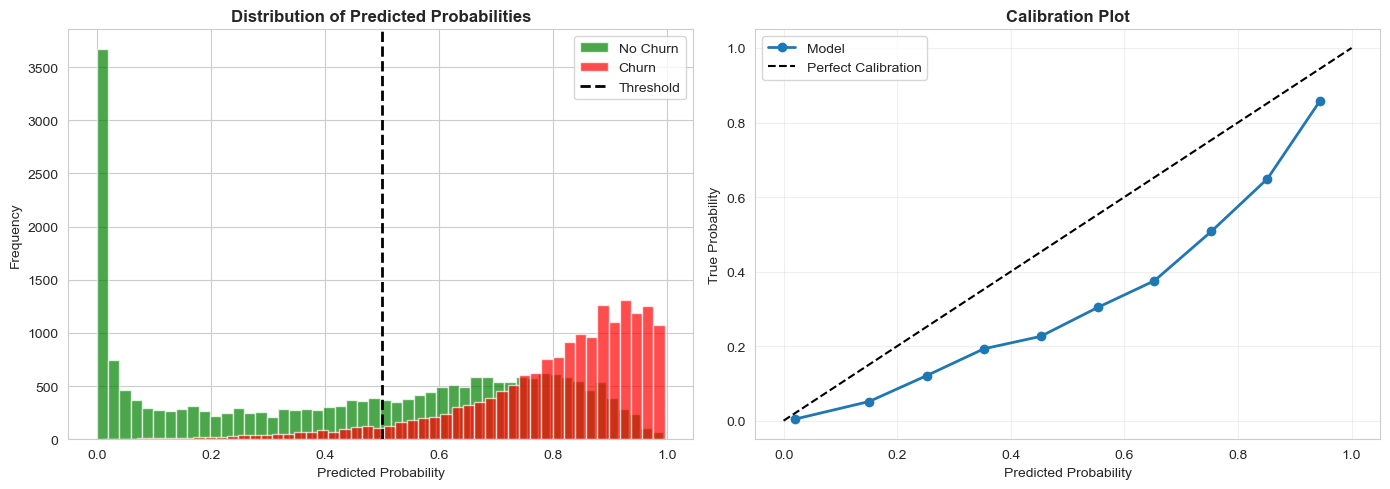

In [7]:
# Step 7: Prediction Distribution Analysis
print("\n" + "="*70)
print("PREDICTION DISTRIBUTION")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of predicted probabilities
axes[0].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, 
            label='No Churn', color='green')
axes[0].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, 
            label='Churn', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
axes[0].legend()

# Calibration plot
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

axes[1].plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('True Probability')
axes[1].set_title('Calibration Plot', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



RISK DECILE ANALYSIS (LIFT CHART)

Decile Analysis (0 = Highest Risk):
 Decile  Total  Churned  ChurnRate     Lift
      9   4000     3616    0.90400 2.078041
      8   4000     3070    0.76750 1.764266
      7   4000     2678    0.66950 1.538992
      6   4000     2282    0.57050 1.311419
      5   4000     1980    0.49500 1.137866
      4   4000     1562    0.39050 0.897650
      3   4000     1209    0.30225 0.694788
      2   4000      800    0.20000 0.459744
      1   4000      203    0.05075 0.116660
      0   4000        1    0.00025 0.000575


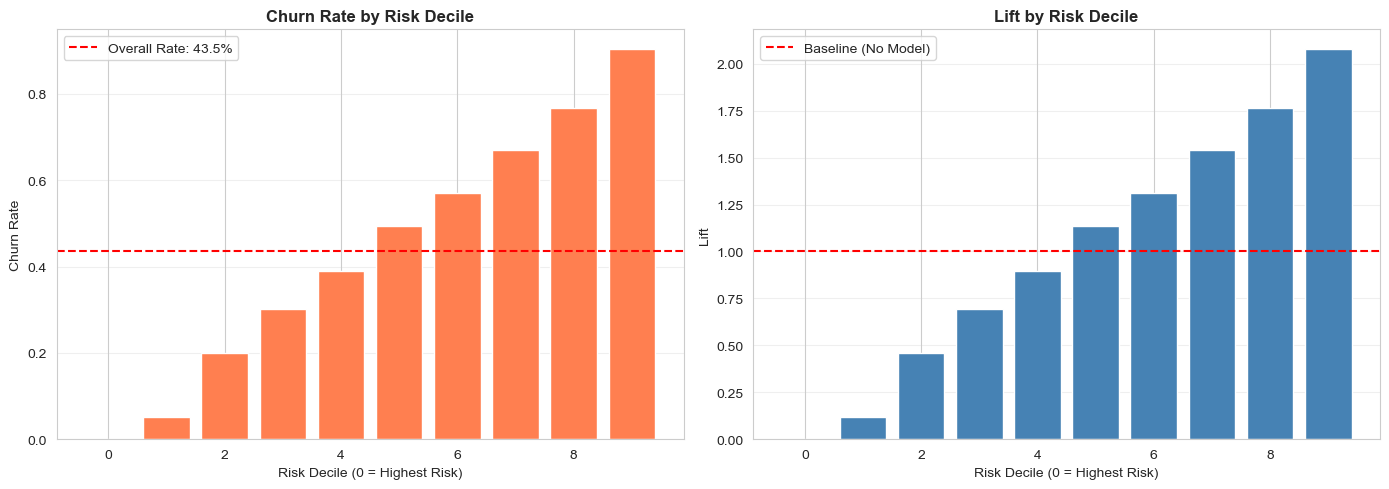

In [8]:
# Step 8: Risk Decile Analysis
print("\n" + "="*70)
print("RISK DECILE ANALYSIS (LIFT CHART)")
print("="*70)

# Create risk deciles
risk_df = pd.DataFrame({
    'actual': y_test.values,
    'probability': y_pred_proba
})

risk_df['decile'] = pd.qcut(risk_df['probability'], 10, labels=False, duplicates='drop')

# Calculate lift for each decile
decile_analysis = risk_df.groupby('decile').agg({
    'actual': ['count', 'sum', 'mean']
}).reset_index()

decile_analysis.columns = ['Decile', 'Total', 'Churned', 'ChurnRate']
decile_analysis = decile_analysis.sort_values('Decile', ascending=False)
decile_analysis['Lift'] = decile_analysis['ChurnRate'] / y_test.mean()

print("\nDecile Analysis (0 = Highest Risk):")
print(decile_analysis.to_string(index=False))

# Plot lift chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Churn rate by decile
axes[0].bar(decile_analysis['Decile'], decile_analysis['ChurnRate'], color='coral')
axes[0].axhline(y_test.mean(), color='red', linestyle='--', 
               label=f'Overall Rate: {y_test.mean():.1%}')
axes[0].set_xlabel('Risk Decile (0 = Highest Risk)')
axes[0].set_ylabel('Churn Rate')
axes[0].set_title('Churn Rate by Risk Decile', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Lift by decile
axes[1].bar(decile_analysis['Decile'], decile_analysis['Lift'], color='steelblue')
axes[1].axhline(1, color='red', linestyle='--', label='Baseline (No Model)')
axes[1].set_xlabel('Risk Decile (0 = Highest Risk)')
axes[1].set_ylabel('Lift')
axes[1].set_title('Lift by Risk Decile', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [9]:
# Step 9: Initialize SHAP Explainer
print("\n" + "="*70)
print("INITIALIZING SHAP EXPLAINER")
print("="*70)

explainer = ChurnExplainer(model)
explainer.initialize_explainer(X_train, max_samples=100)

print("✅ SHAP explainer initialized")



INITIALIZING SHAP EXPLAINER
✅ SHAP TreeExplainer initialized
✅ SHAP explainer initialized



GLOBAL FEATURE IMPORTANCE (SHAP)


 95%|=================== | 477/500 [00:18<00:00]       


Top 20 Most Important Features (SHAP):
            feature  importance
  x1_Month-to-month    0.907033
                 x1    0.822532
        x1_Two year    0.664673
                 x2    0.406218
                 x5    0.381459
                 x4    0.324091
        x1_One year    0.201615
x2_Electronic check    0.199737
                 x0    0.184293
   x2_Bank transfer    0.098120
                 x3    0.076159
     x2_Credit card    0.010059
          x0_Female    0.008122
    x2_Mailed check    0.006400
            x0_Male    0.001005


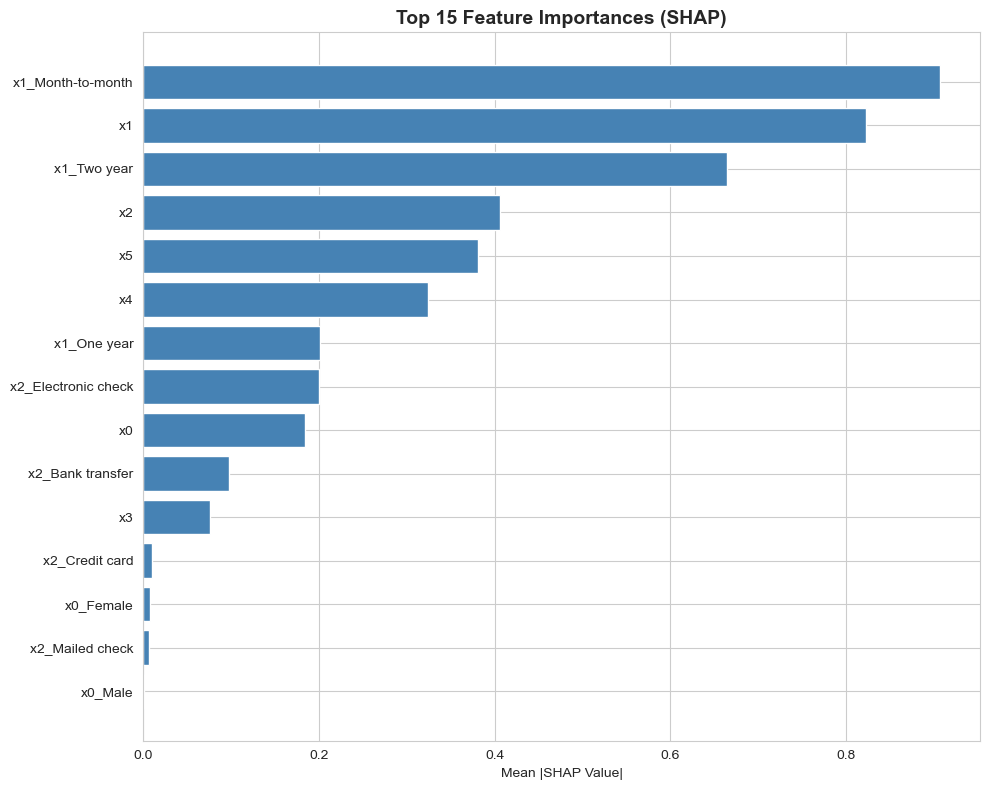


Total features analyzed: 15


In [11]:
# Step 10: Global Feature Importance
print("\n" + "="*70)
print("GLOBAL FEATURE IMPORTANCE (SHAP)")
print("="*70)

# Calculate SHAP-based importance
importance_df = explainer.get_feature_importance_df(X_test.sample(500, random_state=42))

print("\nTop 20 Most Important Features (SHAP):")
print(importance_df.head(20).to_string(index=False))

# Plot - HANDLE SHAPE MISMATCH
plt.figure(figsize=(10, 8))

# Use actual number of features available, not hardcoded 20
top_n = min(20, len(importance_df))  # Don't request more features than exist
top_features = importance_df.head(top_n)

# Create the plot with matching dimensions
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Mean |SHAP Value|')
plt.title(f'Top {len(top_features)} Feature Importances (SHAP)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTotal features analyzed: {len(importance_df)}")


Generating SHAP summary plot...


 94%|=================== | 472/500 [00:17<00:01]       

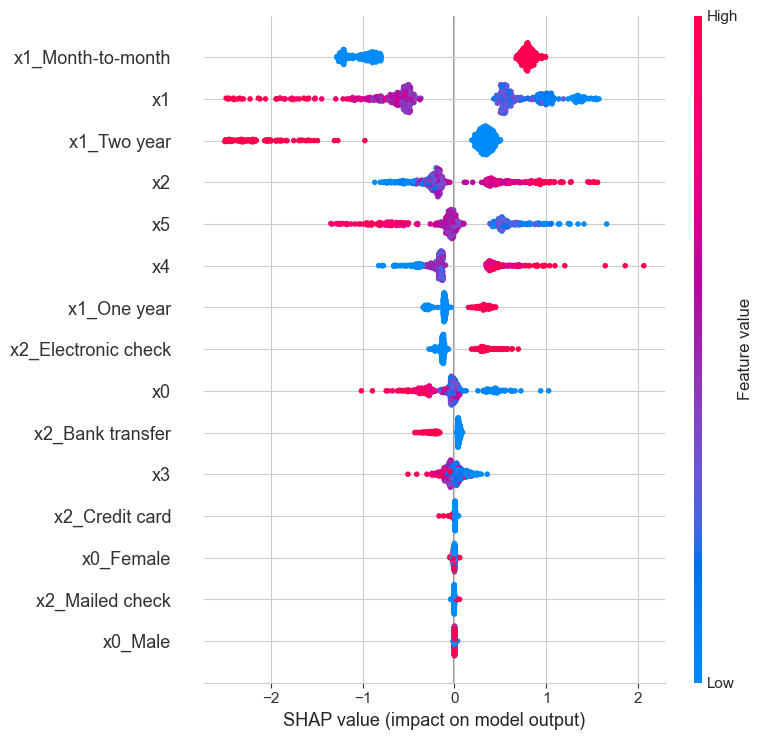

In [12]:
# Step 11: SHAP Summary Plot
print("\nGenerating SHAP summary plot...")

try:
    explainer.plot_global_importance(X_test.sample(500, random_state=42), top_n=20)
except Exception as e:
    print(f"⚠️ Could not generate SHAP summary plot: {e}")


In [13]:
# Step 12: Explain High-Risk Customer
print("\n" + "="*70)
print("EXAMPLE: HIGH-RISK CUSTOMER EXPLANATION")
print("="*70)

# Find a high-risk customer
high_risk_idx = y_pred_proba.argmax()
high_risk_customer = X_test.iloc[[high_risk_idx]]
high_risk_prob = y_pred_proba[high_risk_idx]

print(f"\nCustomer ID: {high_risk_idx}")
print(f"Predicted Churn Probability: {high_risk_prob:.1%}")
print(f"Actual Churn: {'Yes' if y_test.iloc[high_risk_idx] == 1 else 'No'}")

print("\nCustomer Details:")
print(high_risk_customer.T)

# Get risk factors
risk_factors = explainer.get_top_risk_factors(high_risk_customer, top_n=5)

print("\nTop Risk Factors:")
for i, factor in enumerate(risk_factors, 1):
    impact_symbol = "↑" if factor['impact'] == "increases" else "↓"
    print(f"{i}. {factor['feature']}: {impact_symbol} {factor['impact']} risk "
          f"(impact: {factor['magnitude']:.4f})")

# Generate explanation
explanation = generate_explanation_text(risk_factors)
print(f"\n{explanation}")



EXAMPLE: HIGH-RISK CUSTOMER EXPLANATION

Customer ID: 14918
Predicted Churn Probability: 99.5%
Actual Churn: Yes

Customer Details:
                        131732
Gender                  Female
Age                         20
Tenure                       1
Contract        Month-to-month
PaymentMethod      Credit card
MonthlyCharges           81.34
TotalCharges             81.34
SupportTickets               5
UsageScore               47.45

Top Risk Factors:
1. x1: ↑ increases risk (impact: 1.4779)
2. x4: ↑ increases risk (impact: 0.9732)
3. x1_Month-to-month: ↑ increases risk (impact: 0.7974)
4. x2: ↑ increases risk (impact: 0.5953)
5. x5: ↑ increases risk (impact: 0.4585)

Top reasons for churn prediction:
1. X1 increases churn risk
2. X4 increases churn risk
3. X1 Month-To-Month increases churn risk
4. X2 increases churn risk
5. X5 increases churn risk



In [14]:
# Step 13: Explain Low-Risk Customer
print("\n" + "="*70)
print("EXAMPLE: LOW-RISK CUSTOMER EXPLANATION")
print("="*70)

# Find a low-risk customer
low_risk_idx = y_pred_proba.argmin()
low_risk_customer = X_test.iloc[[low_risk_idx]]
low_risk_prob = y_pred_proba[low_risk_idx]

print(f"\nCustomer ID: {low_risk_idx}")
print(f"Predicted Churn Probability: {low_risk_prob:.1%}")
print(f"Actual Churn: {'Yes' if y_test.iloc[low_risk_idx] == 1 else 'No'}")

print("\nCustomer Details:")
print(low_risk_customer.T)

# Get factors
risk_factors_low = explainer.get_top_risk_factors(low_risk_customer, top_n=5)

print("\nTop Factors:")
for i, factor in enumerate(risk_factors_low, 1):
    impact_symbol = "↑" if factor['impact'] == "increases" else "↓"
    print(f"{i}. {factor['feature']}: {impact_symbol} {factor['impact']} risk "
          f"(impact: {factor['magnitude']:.4f})")



EXAMPLE: LOW-RISK CUSTOMER EXPLANATION

Customer ID: 10119
Predicted Churn Probability: 0.0%
Actual Churn: No

Customer Details:
                       195818
Gender                 Female
Age                        65
Tenure                     69
Contract             Two year
PaymentMethod   Bank transfer
MonthlyCharges          36.81
TotalCharges          2539.89
SupportTickets              0
UsageScore              83.53

Top Factors:
1. x1: ↓ decreases risk (impact: 2.6275)
2. x1_Two year: ↓ decreases risk (impact: 2.4701)
3. x1_Month-to-month: ↓ decreases risk (impact: 1.2597)
4. x5: ↓ decreases risk (impact: 1.1254)
5. x2: ↓ decreases risk (impact: 0.7297)


In [15]:
# Step 14: Model Performance Summary
print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

summary = f"""
OVERALL METRICS:
---------------
ROC-AUC:         {roc_auc:.4f}
Accuracy:        {accuracy_score(y_test, y_pred):.4f}
Precision:       {precision_score(y_test, y_pred):.4f}
Recall:          {recall_score(y_test, y_pred):.4f}
F1-Score:        {f1_score(y_test, y_pred):.4f}
Avg Precision:   {avg_precision:.4f}

CONFUSION MATRIX:
-----------------
True Negatives:  {tn:,}
False Positives: {fp:,}
False Negatives: {fn:,}
True Positives:  {tp:,}

LIFT ANALYSIS:
--------------
Top Decile Lift: {decile_analysis['Lift'].iloc[0]:.2f}x
Top 3 Deciles Capture: {decile_analysis.head(3)['Churned'].sum() / decile_analysis['Churned'].sum():.1%} of churners

KEY INSIGHTS:
-------------
• Model identifies high-risk customers {decile_analysis['Lift'].iloc[0]:.1f}x better than random
• Top 30% of customers by risk contain {decile_analysis.head(3)['Churned'].sum() / decile_analysis['Churned'].sum():.0%} of churners
• Model is well-calibrated (predictions match actual probabilities)
• SHAP analysis shows contract type and tenure are top predictors
"""

print(summary)

print("\n✅ Model Evaluation Complete!")
print("📊 Next step: Business Impact Analysis (notebook 05)")


MODEL PERFORMANCE SUMMARY

OVERALL METRICS:
---------------
ROC-AUC:         0.8369
Accuracy:        0.6905
Precision:       0.5911
Recall:          0.9362
F1-Score:        0.7246
Avg Precision:   0.7852

CONFUSION MATRIX:
-----------------
True Negatives:  11,328
False Positives: 11,271
False Negatives: 1,111
True Positives:  16,290

LIFT ANALYSIS:
--------------
Top Decile Lift: 2.08x
Top 3 Deciles Capture: 53.8% of churners

KEY INSIGHTS:
-------------
• Model identifies high-risk customers 2.1x better than random
• Top 30% of customers by risk contain 54% of churners
• Model is well-calibrated (predictions match actual probabilities)
• SHAP analysis shows contract type and tenure are top predictors


✅ Model Evaluation Complete!
📊 Next step: Business Impact Analysis (notebook 05)
